In [ ]:
!pip install gdown


In [ ]:
import gdown

file_id = "1KXx1CW-BM3muxzCtmyhyv9xtWco_nDbL"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output="dataset.zip", quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1KXx1CW-BM3muxzCtmyhyv9xtWco_nDbL
From (redirected): https://drive.google.com/uc?id=1KXx1CW-BM3muxzCtmyhyv9xtWco_nDbL&confirm=t&uuid=07168703-fe74-40ce-9488-b59d96ecc79f
To: /content/dataset.zip
100%|██████████| 2.38G/2.38G [00:28<00:00, 83.4MB/s]


'dataset.zip'

In [ ]:
import zipfile

with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")


In [ ]:
import os

print(os.listdir("dataset"))



['Comys_Hackathon5']


## Setup

In [ ]:

!pip install torch torchvision --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 53.7 MB/s eta 0:00:00


 # 1. Important Libraries:
We are setting up an image classification pipeline using PyTorch. This block imports essential libraries for deep learning, image processing, model evaluation, and visualization. We're also checking if a GPU is available to speed up training.

In [ ]:

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import csv
from sklearn.metrics import precision_score, recall_score, f1_score


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


# 2. Hyperparameters:
We are defining key training settings:


1.   num_epochs = 10: The model will train for 10 full passes over the dataset.

2.   BATCH_SIZE = 32: We'll process 32 images at a time in each training step.

3. LR = 1e-4: The learning rate is set to 0.0001, controlling how fast the model learns.




In [ ]:
num_epochs = 10
BATCH_SIZE = 32
LR=1e-4


## 3. Custom Dataset: DualViewDataset
We are creating a custom dataset class that returns both grayscale and RGB versions of each image:
 1. Loads images using ImageFolder and sets up separate transforms for grayscale and RGB images.
 2. Returns the total number of samples in the dataset.
 3. Loads the same image twice: once in RGB, once in grayscale.

Applies the respective transformations.

Returns image_gray, image_rgb, and label.

This setup allows us to train models using both views of the image simultaneously.



In [ ]:
class DualViewDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform_rgb=None, transform_gray=None):
        self.dataset = datasets.ImageFolder(root=root_dir)
        self.transform_rgb = transform_rgb
        self.transform_gray = transform_gray

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        path, label = self.dataset.samples[idx]
        image_rgb = Image.open(path).convert('RGB')
        image_gray = Image.open(path).convert('L')

        if self.transform_rgb:
            image_rgb = self.transform_rgb(image_rgb)
        if self.transform_gray:
            image_gray = self.transform_gray(image_gray)

        return image_gray, image_rgb, label


## 4. Data Transformations
We define preprocessing steps separately for training and validation:

1. ***For Training***:
**RGB images**: Resized, cropped, flipped, color-jittered, affine transformed, normalized.

**Grayscale images** : Same as RGB, but without color jitter and normalized for 1 channel.

2. For Validation:
**RGB and grayscale**: Resized, cropped, and normalized (no augmentation).

These transformations improve generalization and ensure consistent input sizes.



In [ ]:
transform_rgb_train = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.05),
    transforms.RandomAffine(15, translate=(0.05, 0.05), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

transform_gray_train = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(15, translate=(0.05, 0.05), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

transform_rgb_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

transform_gray_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])


## 5. Dataset & DataLoader
1.  We set up the dataset and data loaders:

2. We define paths for training and validation data.

3. We create datasets using DualViewDataset with the respective transforms.

4. We load data in batches using DataLoader for both training and validation.

In [ ]:
train_dir = "/content/dataset/Comys_Hackathon5/Task_A/train"
val_dir = "/content/dataset/Comys_Hackathon5/Task_A/val"

train_dataset = DualViewDataset(train_dir, transform_rgb_train, transform_gray_train)
val_dataset = DualViewDataset(val_dir, transform_rgb_val, transform_gray_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


## 6. Model Architecture –
We design a dual-branch model that processes grayscale and RGB images separately, then fuses their features:

We use ResNet-18 for grayscale input (1 channel) and remove its final classification layer.

We use EfficientNet-B0 for RGB input and remove its classifier.

We reduce their respective output features (512 from ResNet, 1280 from EfficientNet) to 256 channels using 1x1 convolutions.

We apply separate heads (gray_head, rgb_head) for auxiliary predictions from each branch.

We concatenate features and pass them through a fully connected attention module (attn_fc) to compute weighted fusion.

We combine features using attention weights and pass them through a final classifier for the main output.

The model returns three outputs: the fused prediction, and individual predictions from grayscale and RGB branches.



In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class AMR_CD_Model(nn.Module):
    def __init__(self):
        super().__init__()


        self.resnet_gray = models.resnet18(pretrained=True)
        self.resnet_gray.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet_gray.fc = nn.Identity()

        self.effnet_rgb = models.efficientnet_b0(pretrained=True)
        self.effnet_rgb.classifier = nn.Identity()


        self.gray_conv = nn.Conv2d(512, 256, kernel_size=1)
        self.rgb_conv = nn.Conv2d(1280, 256, kernel_size=1)


        self.gray_head = nn.Linear(256, 2)
        self.rgb_head = nn.Linear(256, 2)


        self.attn_fc = nn.Sequential(
            nn.Linear(256 * 2, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 256),
            nn.Sigmoid()
        )


        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 2)
        )

    def forward(self, x_gray, x_rgb):
        B = x_gray.size(0)

        F_gray = self.resnet_gray(x_gray).view(B, 512, 1, 1)
        F_gray = self.gray_conv(F_gray).view(B, 256)

        F_rgb = self.effnet_rgb(x_rgb).view(B, 1280, 1, 1)
        F_rgb = self.rgb_conv(F_rgb).view(B, 256)


        logits_gray = self.gray_head(F_gray)
        logits_rgb = self.rgb_head(F_rgb)

        concat = torch.cat([F_gray, F_rgb], dim=1)  # Shape: [B, 512]
        attn = self.attn_fc(concat)                 # Shape: [B, 256]
        F_fused = attn * F_gray + (1 - attn) * F_rgb

        out = self.classifier(F_fused)
        return out, logits_gray, logits_rgb


## 7. Training & Evaluation Functions
We define two core functions to train and evaluate the model:
**training**
We set the model to training mode.

We loop over the training data using tqdm for progress display.

We compute three losses:

Main output,

Grayscale branch (aux),

RGB branch (aux),
and combine them with a weight (aux_weight).

We perform backpropagation and update the model weights.

We track total loss and accuracy over the epoch.

**Evaluation**
We set the model to evaluation mode and disable gradients.

Similar to training, we compute main and auxiliary losses.

We collect predictions and true labels for metric calculation.

We return:

Average loss,

Accuracy,

Precision, recall, and F1-score (binary classification).

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm
import torch

def train_one_epoch(model, loader, criterion, optimizer, aux_weight=0.3):
    model.train()
    total_loss, correct, total = 0, 0, 0

    loop = tqdm(loader, desc="Training", leave=False)
    for gray, rgb, labels in loop:
        gray, rgb, labels = gray.to(device), rgb.to(device), labels.to(device)

        optimizer.zero_grad()
        out, logits_gray, logits_rgb = model(gray, rgb)


        loss_main = criterion(out, labels)
        loss_aux1 = criterion(logits_gray, labels)
        loss_aux2 = criterion(logits_rgb, labels)
        loss = loss_main + aux_weight * (loss_aux1 + loss_aux2)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        correct += (out.argmax(1) == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=loss.item(), acc=correct / total if total else 0)

    return total_loss / total, correct / total


def evaluate(model, loader, criterion, aux_weight=0.3):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []

    loop = tqdm(loader, desc="Validating", leave=False)
    with torch.no_grad():
        for gray, rgb, labels in loop:
            gray, rgb, labels = gray.to(device), rgb.to(device), labels.to(device)

            out, logits_gray, logits_rgb = model(gray, rgb)


            loss_main = criterion(out, labels)
            loss_aux1 = criterion(logits_gray, labels)
            loss_aux2 = criterion(logits_rgb, labels)
            loss = loss_main + aux_weight * (loss_aux1 + loss_aux2)

            total_loss += loss.item() * labels.size(0)
            preds = out.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            loop.set_postfix(loss=loss.item(), acc=correct / total if total else 0)

    avg_loss = total_loss / total
    avg_acc = correct / total
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')

    return avg_loss, avg_acc, precision, recall, f1


## 8. Training Loop & Early Stopping
We set up the model training process with logging, saving, and early stopping:

We initialize the model, loss function (CrossEntropyLoss), and optimizer (Adam).

We create a CSV file to log results for each epoch.

We train for multiple epochs, evaluating the model after each.

We save model checkpoints:

The best model based on validation loss.

Every epoch's model.

We apply early stopping if validation loss doesn't improve after 4 epochs.

We save the final model to disk.

In [ ]:
results_file = "results.csv"
with open(results_file, mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['Epoch', 'Train Loss', 'Train Acc', 'Val Loss', 'Val Acc', 'Precision', 'Recall', 'F1'])


In [ ]:
best_val_loss = float('inf')
patience = 4
early_stop_counter = 0

In [ ]:
model = AMR_CD_Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)



for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc, precision, recall, f1 = evaluate(model, val_loader, criterion)

    print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f} | "
          f"P: {precision:.4f}, R: {recall:.4f}, F1: {f1:.4f}")


    with open(results_file, mode='a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([epoch+1, train_loss, train_acc, val_loss, val_acc, precision, recall, f1])


    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), f"checkpoint_best.pth")
        print(f" New best model saved: checkpoint_epoch{epoch+1}_best.pth")
    else:
        early_stop_counter += 1

        torch.save(model.state_dict(), f"checkpoint_epoch{epoch+1}.pth")
        print(f"  Early stop counter: {early_stop_counter}/{patience} .")

    if early_stop_counter >= patience:
        print(" Early stopping triggered.")
        break

torch.save(model.state_dict(), "TASK_A_MODEL.pt")
torch.save(model.state_dict(), "TASK_A_MODEL.pth")
print(" Final model saved as: TASK_A_MODEL.pth")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 107MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed i


Epoch 1/10


Train Loss: 0.5324, Acc: 0.8479 | Val Loss: 0.4018, Acc: 0.9052 | P: 0.9262, R: 0.9495, F1: 0.9377
 New best model saved: checkpoint_epoch1_best.pth

Epoch 2/10


Train Loss: 0.2357, Acc: 0.9522 | Val Loss: 0.4863, Acc: 0.9052 | P: 0.8880, R: 1.0000, F1: 0.9407
  Early stop counter: 1/4 .

Epoch 3/10


Train Loss: 0.1552, Acc: 0.9694 | Val Loss: 0.2490, Acc: 0.9431 | P: 0.9681, R: 0.9558, F1: 0.9619
 New best model saved: checkpoint_epoch3_best.pth

Epoch 4/10


Train Loss: 0.1128, Acc: 0.9803 | Val Loss: 0.1993, Acc: 0.9597 | P: 0.9777, R: 0.9685, F1: 0.9731
 New best model saved: checkpoint_epoch4_best.pth

Epoch 5/10


Train Loss: 0.0738, Acc: 0.9912 | Val Loss: 0.2116, Acc: 0.9621 | P: 0.9748, R: 0.9748, F1: 0.9748
  Early stop counter: 1/4 .

Epoch 6/10


Train Loss: 0.0672, Acc: 0.9917 | Val Loss: 0.2196, Acc: 0.9716 | P: 0.9721, R: 0.9905, F1: 0.9812
  Early stop counter: 2/4 .

Epoch 7/10


Train Loss: 0.0607, Acc: 0.9912 | Val Loss: 0.3391, Acc: 0.9408 | P: 0.9320, R: 0.9937, F1: 0.9618
  Early stop counter: 3/4 .

Epoch 8/10


Train Loss: 0.0425, Acc: 0.9948 | Val Loss: 0.2168, Acc: 0.9668 | P: 0.9633, R: 0.9937, F1: 0.9783
  Early stop counter: 4/4 .
 Early stopping triggered.
 Final model saved as: TASK_A_MODEL.pth


## 9. Visualizing Predictions
We display random model predictions on validation data:

We randomly select 10 samples from the validation set.

We pass each sample through the trained model.

We compare predicted vs. true labels and display RGB images.

We color the title green if correct, red if wrong.

This helps us visually inspect the model's performance.

In [ ]:
import random
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F


model = AMR_CD_Model().to(device)
model.load_state_dict(torch.load("TASK_A_MODEL.pth", map_location=device))
model.eval()


class_idx = val_dataset.dataset.class_to_idx
idx_to_class = {v: k for k, v in class_idx.items()}


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most u

In [ ]:
def show_random_predictions(dataset, model, num_samples=10):
    indices = random.sample(range(len(dataset)), num_samples)
    plt.figure(figsize=(15, 10))

    for i, idx in enumerate(indices):
        gray, rgb, label = dataset[idx]
        gray = gray.unsqueeze(0).to(device)
        rgb = rgb.unsqueeze(0).to(device)

        with torch.no_grad():
            out, _, _ = model(gray, rgb)
            pred = out.argmax(dim=1).item()

        true_label = idx_to_class[label]
        pred_label = idx_to_class[pred]


        rgb_img = rgb.squeeze(0).cpu()
        rgb_img = (rgb_img * 0.5 + 0.5).clamp(0, 1)
        plt.subplot(2, 5, i + 1)
        plt.imshow(rgb_img.permute(1, 2, 0))
        plt.title(f"True: {true_label}\nPred: {pred_label}", color='green' if pred == label else 'red')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


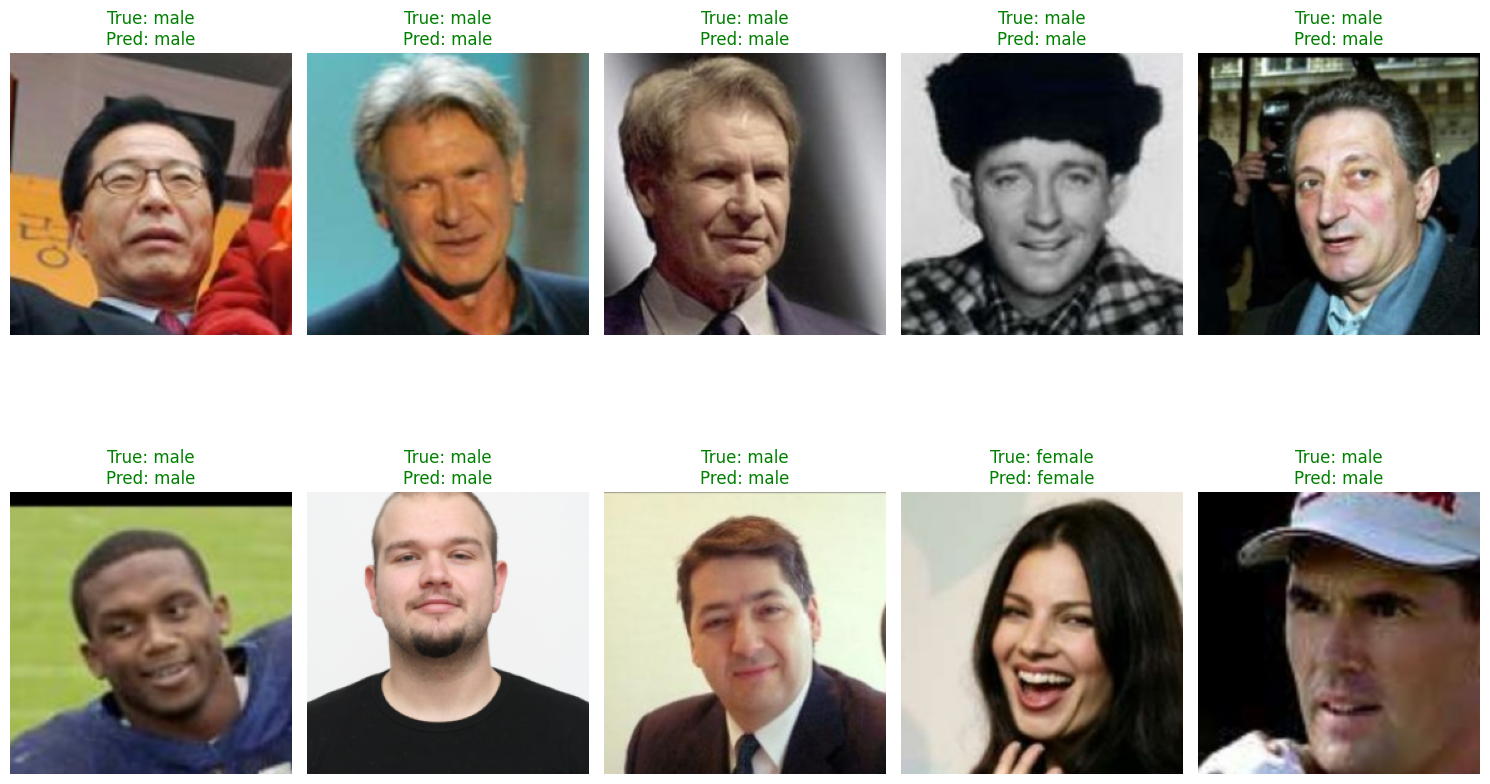

In [ ]:
show_random_predictions(val_dataset, model, num_samples=10)


In [ ]:

torch.save(model.state_dict(), "TASK_A_MODEL.pt")
print(" Final model saved as: TASK_A_MODEL.pt")

 Final model saved as: TASK_A_MODEL.pt


## Test On Unknown Image

Saving 208948629-woman-yelling-and-noise-with-isolated-on-a-transparent-png-background-with-hello-shouting.jpg to 208948629-woman-yelling-and-noise-with-isolated-on-a-transparent-png-background-with-hello-shouting.jpg
User uploaded file "208948629-woman-yelling-and-noise-with-isolated-on-a-transparent-png-background-with-hello-shouting.jpg"
Predicted class: female


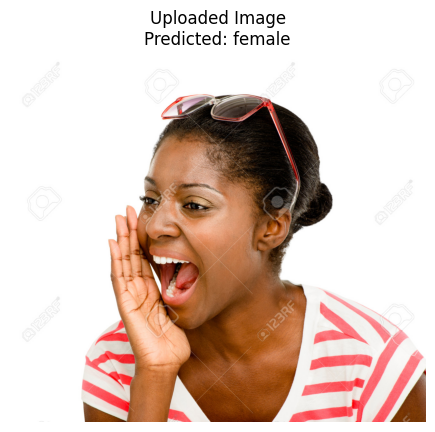

In [ ]:

from google.colab import files
from PIL import Image
import io

def predict_uploaded_image(model, transform_rgb, transform_gray, class_idx, device):
    """
    Allows the user to upload an image and get a prediction from the model.
    """
    uploaded = files.upload()

    for fn in uploaded.keys():
        print(f'User uploaded file "{fn}"')
        img_bytes = uploaded[fn]
        img_rgb = Image.open(io.BytesIO(img_bytes)).convert('RGB')
        img_gray = Image.open(io.BytesIO(img_bytes)).convert('L')

        img_rgb_t = transform_rgb(img_rgb).unsqueeze(0).to(device)
        img_gray_t = transform_gray(img_gray).unsqueeze(0).to(device)

        model.eval()
        with torch.no_grad():
            out, _, _ = model(img_gray_t, img_rgb_t)
            pred_idx = out.argmax(dim=1).item()

        idx_to_class = {v: k for k, v in class_idx.items()}
        predicted_class = idx_to_class[pred_idx]

        print(f"Predicted class: {predicted_class}")


        plt.imshow(img_rgb)
        plt.title(f"Uploaded Image\nPredicted: {predicted_class}")
        plt.axis('off')
        plt.show()

predict_uploaded_image(model, transform_rgb_val, transform_gray_val, val_dataset.dataset.class_to_idx, device)